In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from circuit_knitting.utils.simulation import ExactSampler

exact_sampler = ExactSampler()

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

service = QiskitRuntimeService()

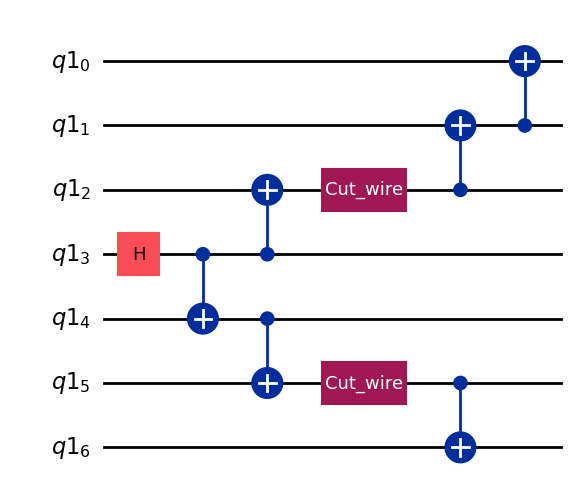

In [3]:
#qc = get_ghz_circ_static(num_qubit=6)
num_qubit=7
qr=QuantumRegister(num_qubit)
cr2=ClassicalRegister(num_qubit,name="cr2")                     
qc=QuantumCircuit(qr)
qc.h(3)
qc.cx(3,4)
qc.cx(3,2)

qc.cx(4,5)
qc.append(CutWire(), [5])
qc.append(CutWire(), [2])
qc.cx(2,1)
qc.cx(1,0)
qc.cx(5,6)
qc.draw("mpl")

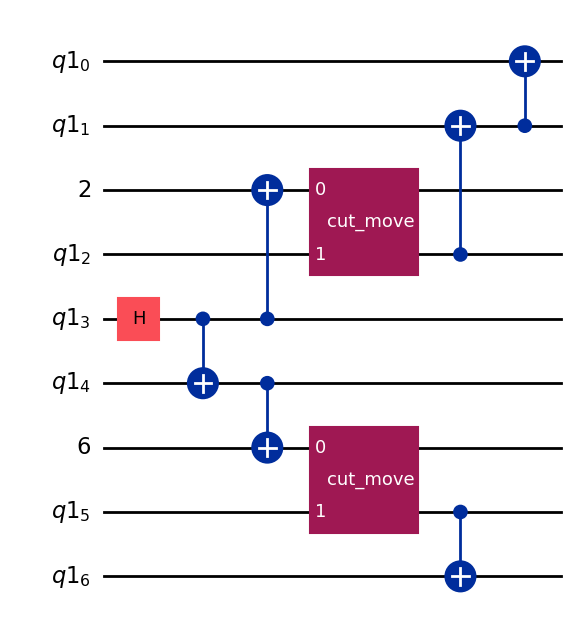

In [4]:
observable = SparsePauliOp(["ZIIIIII"])
qc_1 = cut_wires(qc)
qc_1.draw("mpl")

In [5]:
observable_expanded_paulis = expand_observables(observable.paulis, qc, qc_1)
observable_expanded_paulis

PauliList(['ZIIIIIIII'])

In [6]:
partitioned_problem = partition_problem(
    circuit=qc_1, observables=observable_expanded_paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
subobservables

{0: PauliList(['III']), 1: PauliList(['IIII']), 2: PauliList(['ZI'])}

In [7]:
partitioned_problem

PartitionedCuttingProblem(subcircuits={0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D446E9B4D0>, 1: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D449EFC350>, 2: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D44A0C0A50>}, bases=[<circuit_knitting.cutting.qpd.qpd_basis.QPDBasis object at 0x000001D445D36F50>, <circuit_knitting.cutting.qpd.qpd_basis.QPDBasis object at 0x000001D445D36450>], subobservables={0: PauliList(['III']), 1: PauliList(['IIII']), 2: PauliList(['ZI'])})

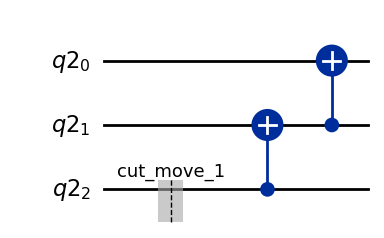

In [8]:
subcircuits[0].draw("mpl")

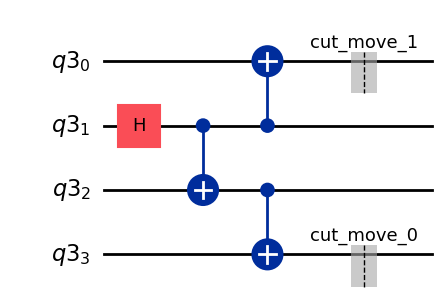

In [9]:
subcircuits[1].draw("mpl")

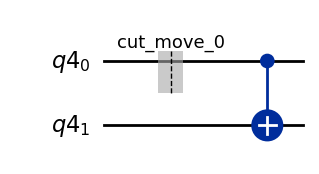

In [10]:
subcircuits[2].draw("mpl")

In [12]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
service = QiskitRuntimeService()


subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=100,
)

# Specify a system to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1, init_method="qubit_reuse")
qc_transpiled_subexperiments =  {
    label: pm.run(subexperiment)
    for label, subexperiment in subexperiments.items()
}                             
sampler = Sampler(backend=aer)
#result_osaka = sampler.run(qc_transpiled_list_real).result()




#sampler = SamplerV2()
results = {
    label: sampler.run(subexperiment, shots=2**12).result()
    for label, subexperiment in qc_transpiled_subexperiments.items()
}

"""results = {
    label: exact_sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}
"""

'results = {\n    label: exact_sampler.run(subexperiment).result()\n    for label, subexperiment in subexperiments.items()\n}\n'

In [13]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

AttributeError: 'DataBin' object has no attribute 'observable_measurements'

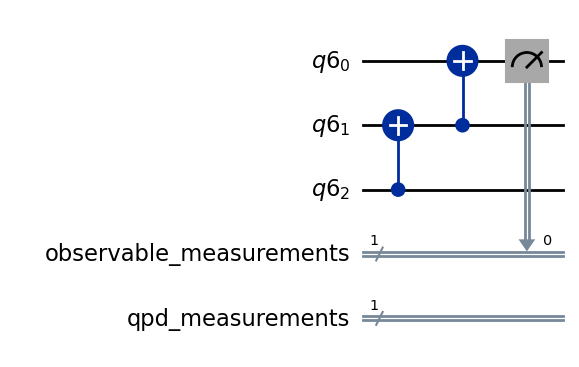

In [19]:
subexperiments[0][0].draw("mpl") # if qubit reuse were not used

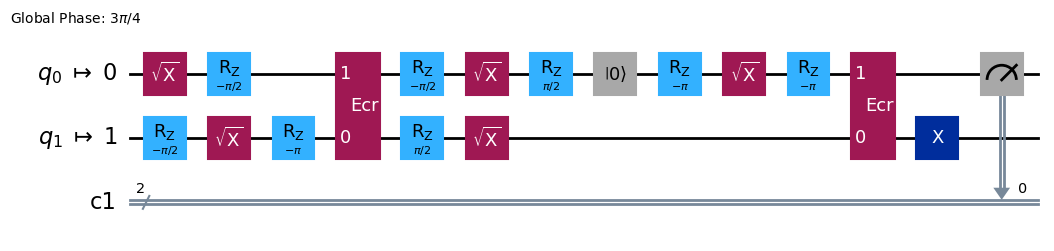

In [17]:
qc_transpiled_subexperiments[0][0].draw("mpl",idle_wires=False)